In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from boruta.boruta_py import BorutaPy # boruta requer numpy 1.23.1 ou abaixo
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
# Carregamento dos dados
dataset = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [4]:
# Converter TotalCharges para float
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [5]:
# verificar nan em dataset
display(dataset.isna().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
# Remover a coluna 'customerID'
dataset.drop('customerID', axis=1, inplace=True)

# Selecionar colunas categóricas, mantendo as colunas do tipo int e float no DataFrame
categorical_cols = dataset.select_dtypes(include=['object']).columns.tolist()

# Criar um DataFrame com as colunas categóricas aplicando label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() 
dataset_dummies = dataset.copy()
for col in categorical_cols:
    dataset_dummies[col] = label_encoder.fit_transform(dataset[col])

# Separar as features e o target
scaler = StandardScaler()
features_scaled = scaler.fit_transform(dataset_dummies.drop('TotalCharges', axis=1))  # remove 'TotalCharges' from the features

# Após a normalização, a coluna 'TotalCharges' é adicionada de volta ao array de features
features_scaled = np.column_stack((features_scaled, dataset_dummies['TotalCharges']))

imputer = KNNImputer(n_neighbors=10) # Usa o KNN para preencher os valores faltantes
features_imputed = imputer.fit_transform(features_scaled)

# Adicionar 'TotalCharges' como última coluna
dataset['TotalCharges'] = features_imputed[:, -1]

In [7]:
dataset_dummies.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
# Criar um DataFrame com as colunas categóricas aplicando label encoding
dataset_dummies = dataset.copy()
for col in categorical_cols:
    dataset_dummies[col] = label_encoder.fit_transform(dataset[col])

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn'], axis=1)  # Características
y = dataset_dummies['Churn'] 

In [9]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# XGBoost

In [10]:
# Configuração do modelo XGBoost
xg_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.5,
    objective='binary:logistic',
    random_state=42
)

In [11]:
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8099290780141843
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       511
           1       0.70      0.54      0.61       194

    accuracy                           0.81       705
   macro avg       0.77      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705



# Rede neural

In [13]:
# Define the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)), 
    Dropout(0.3), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(1, activation='sigmoid') 
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Print the model summary
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2560      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [14]:
# Convert data types
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [15]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
179/179 [==============================] - 2s 5ms/step - loss: 22.5836 - accuracy: 0.6392 - val_loss: 2.0515 - val_accuracy: 0.7823
Epoch 2/100
179/179 [==============================] - 1s 3ms/step - loss: 4.8843 - accuracy: 0.6527 - val_loss: 1.4994 - val_accuracy: 0.7603
Epoch 3/100
179/179 [==============================] - 1s 3ms/step - loss: 2.0328 - accuracy: 0.6865 - val_loss: 1.4417 - val_accuracy: 0.7618
Epoch 4/100
179/179 [==============================] - 1s 3ms/step - loss: 1.7218 - accuracy: 0.7177 - val_loss: 1.4014 - val_accuracy: 0.7618
Epoch 5/100
179/179 [==============================] - 1s 3ms/step - loss: 1.6586 - accuracy: 0.7211 - val_loss: 1.3779 - val_accuracy: 0.7618
Epoch 6/100
179/179 [==============================] - 1s 3ms/step - loss: 1.5046 - accuracy: 0.7228 - val_loss: 1.3512 - val_accuracy: 0.7618
Epoch 7/100
179/179 [==============================] - 1s 3ms/step - loss: 1.4606 - accuracy: 0.7265 - val_loss: 1.3200 - val_accuracy: 0.761

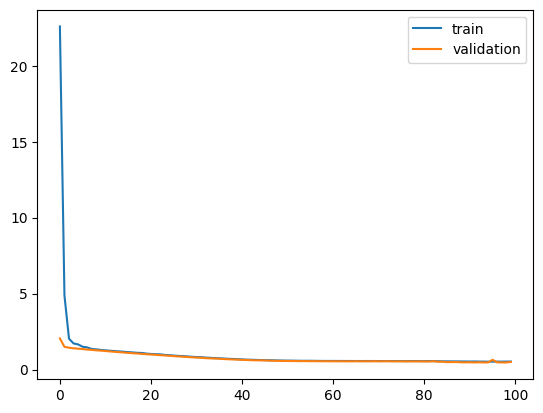

In [16]:
# plotar a curva de perda de um modo
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [17]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 0s 2ms/step - loss: 0.5280 - accuracy: 0.7248
Test Accuracy: 0.7248227000236511


In [18]:
# Classification report
predictions = nn_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, predictions))

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       511
         1.0       0.00      0.00      0.00       194

    accuracy                           0.72       705
   macro avg       0.36      0.50      0.42       705
weighted avg       0.53      0.72      0.61       705



c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# Ensemble

In [19]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

23/23 [==============================] - 0s 2ms/step


In [20]:
# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

In [21]:
# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

Ensemble Accuracy: 0.7957446808510639


In [22]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87       511
         1.0       0.74      0.40      0.52       194

    accuracy                           0.80       705
   macro avg       0.77      0.67      0.70       705
weighted avg       0.79      0.80      0.77       705



# Dataset desbalanceado

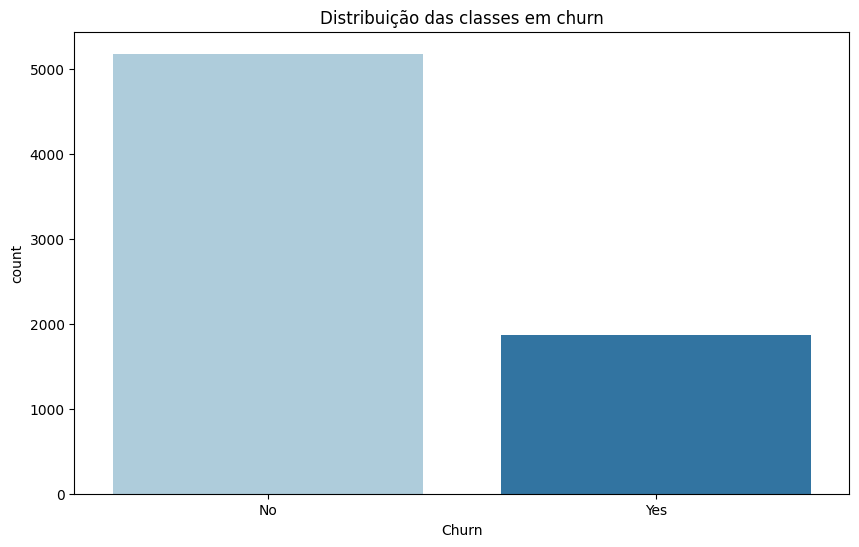

In [23]:
# Gráfico da Distribuição das classes em churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=dataset, palette='Paired', legend=False, hue='Churn')
plt.title('Distribuição das classes em churn')
plt.show()

A classificação desequilibrada é um problema comum no aprendizado de máquina, especialmente no domínio da classificação binária. Isso ocorre quando o conjunto de dados de treinamento tem uma distribuição desigual de classes, levando a um possível viés no modelo treinado. É importante abordar o desequilíbrio de classes para melhorar o desempenho do nosso modelo e garantir sua precisão.

## Modificando os Pesos na Função de Perda

A atribuição de pesos diferentes aos exemplos na função de perda pode ajudar a compensar o desequilíbrio. Isso significa dar maior importância aos exemplos da classe minoritária durante o treinamento do modelo.

**`(y_train == 1).sum()`**: Este trecho conta quantas vezes a classe `1` aparece no conjunto de dados de treino. Isso é feito comparando cada elemento de `y_train` com `1` (verdadeiro onde a condição é atendida) e somando esses valores verdadeiros.

**`(y_train == 0).sum()`**: Similarmente, este trecho conta quantas vezes a classe `0` aparece em `y_train`.

**Divisão**: A divisão do número de exemplos da classe minoritária (1) pelo número de exemplos da classe majoritária(0) calcula um fator de peso. Esse peso será usado para equilibrar as classes, aumentando a importância das instâncias da classe minoritária durante o treinamento do modelo.

In [24]:
# Calculando os pesos para cada classe
weights = (y_train == 1).sum() / (1.0 * (y_train == 0).sum())

xg_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01, 
    max_depth=5,         # Quantidade de camadas, quanto mais camadas, mais complexo
    subsample=0.7,       # Quantidade de amostras por árvore, quanto menos amostras, mais rápido
    colsample_bytree=0.7,# Quantidade de colunas por árvore, quanto menos colunas, mais rápido
    reg_alpha=0.01,      # Regularização L1
    reg_lambda=1.0,      # Regularização L2
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=weights
)

# Treinamento do modelo
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.7801418439716312
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.87       511
         1.0       0.85      0.24      0.38       194

    accuracy                           0.78       705
   macro avg       0.81      0.61      0.62       705
weighted avg       0.80      0.78      0.73       705



In [26]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

23/23 [==============================] - 0s 1ms/step
Ensemble Accuracy: 0.7645390070921986


In [27]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86       511
         1.0       0.87      0.17      0.28       194

    accuracy                           0.76       705
   macro avg       0.81      0.58      0.57       705
weighted avg       0.79      0.76      0.70       705



### Análise de Classe
- **Classe 0 (Majoritária)**
  - **Precisão**: 0.80. Isso indica que 80% das previsões para classe 0 estão corretas.
  - **Recall**: 0.97. Significa que 97% das instâncias reais de classe 0 foram identificadas corretamente pelo modelo.
  - **F1-Score**: 0.87. O F1-score é uma média harmônica de precisão e recall, e um valor de 0.87 sugere um bom equilíbrio entre precisão e recall para esta classe.
  - **Suporte**: 511. Número total de casos reais da classe 0 no conjunto de teste.

- **Classe 1 (Minoritária)**
  - **Precisão**: 0.81. Isto sugere que 81% das previsões de classe 1 pelo modelo estão corretas.
  - **Recall**: 0.35. Apenas 37% das instâncias reais de classe 1 foram identificadas corretamente, o que é bastante baixo.
  - **F1-Score**: 0.49. Este valor mais baixo indica uma baixa eficácia do modelo em equilibrar a precisão e o recall para a classe minoritária.
  - **Suporte**: 194. Número total de casos reais da classe 1 no conjunto de teste.

### Análise Agregada
- **Acurácia**: 0.80. Isso mostra que o modelo acertou 80% das vezes para todas as previsões feitas.
- **Média Macro (avg)**:
  - **Precisão**: 0.80. Média simples das precisões para ambas as classes.
  - **Recall**: 0.66. Média simples dos recalls, afetada negativamente pelo baixo recall da classe 1.
  - **F1-Score**: 0.68. Indica a média do F1-score, que também é puxada para baixo pela performance na classe 1.
- **Média Ponderada (weighted avg)**:
  - **Precisão**: 0.80. Considera o número de instâncias em cada classe, dando mais peso à classe 0.
  - **Recall**: 0.80. Similar à precisão, ponderada pelo suporte.
  - **F1-Score**: 0.77. F1-score ponderado que favorece a classe com mais suporte.

Ponderar os pesos pode aumentar a precisão da classe minoritária, porém o recall e o f1-score podem ser afetados negativamente. Portanto, é importante encontrar um equilíbrio entre as métricas de avaliação para ambas as classes.

# Engenharia de Recursos

Um tema comum em aprendizado de máquina é a seleção de boas características para maximizar o desempenho do modelo.

Para conjuntos de dados estruturados, geralmente há dois passos para escolher um conjunto final de características:

**Engenharia de características**: criação de novas características a partir dos dados (por exemplo, a partir do preço unitário e do volume total, talvez criar uma característica de receita total, igual ao preço vezes o volume).

**Seleção de características**: de um conjunto de características $ p $, selecionar um subconjunto que mantenha (ou até melhore) o desempenho.

## Engenharia de características

In [121]:
# Receita total gerada por cada cliente ao longo do período de tempo (tenure) que ele permaneceu com a empresa.
dataset['TotalRevenue'] = dataset['MonthlyCharges'] * dataset['tenure']

# Contar quantos serviços o cliente tem
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
dataset['ActiveServices'] = dataset[services].apply(lambda x: x.str.contains('Sim').sum(), axis=1)

# Normalizar a coluna 'tenure'
dataset['NormalizedTenure'] = dataset['tenure'] / dataset['tenure'].max()

# Criar uma coluna para identificar clientes idosos com parceiros
dataset['SeniorCitizen_with_Partner'] = ((dataset['SeniorCitizen'] == 1) & (dataset['Partner'] == 'Sim')).astype(int)

# Transformação temporal
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-12 months', '12-24 months', '24-36 months', '36-48 months', '48-60 months', '60-72 months']
dataset['TenureGroup'] = pd.cut(dataset['tenure'], bins=bins, labels=labels, right=False)

# Combinação de Serviços
dataset['Security_and_Backup'] = ((dataset['OnlineSecurity'] == 'Sim') & (dataset['OnlineBackup'] == 'Sim')).astype(int)

# Análise de clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(dataset[['MonthlyCharges', 'tenure']])
dataset['CustomerCluster'] = kmeans.labels_

# Comparar MonthlyCharges com TotalCharges para ver a consistência nas cobranças
dataset['ChargesRatio'] = dataset['MonthlyCharges'] / (dataset['TotalCharges'].replace(' ', np.nan).astype(float))

In [122]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TotalCharges,Churn,TotalRevenue,ActiveServices,NormalizedTenure,SeniorCitizen_with_Partner,TenureGroup,Security_and_Backup,CustomerCluster,ChargesRatio
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,29.85,No,29.85,0,0.013889,0,0-12 months,0,2,1.000000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,1889.50,No,1936.30,0,0.472222,0,24-36 months,0,3,0.030140
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,108.15,Yes,107.70,0,0.027778,0,0-12 months,0,2,0.497920
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,1840.75,No,1903.50,0,0.625000,0,36-48 months,0,0,0.022980
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,151.65,Yes,141.40,0,0.027778,0,0-12 months,0,1,0.466205


In [129]:
# Selecionar colunas categóricas, mantendo as colunas do tipo int e float no DataFrame
categorical_cols = dataset.select_dtypes(include=['object','category']).columns.tolist()

# Criar um DataFrame com as colunas categóricas aplicando label encoding
dataset_dummies = dataset.copy()
for col in categorical_cols:
    dataset_dummies[col] = label_encoder.fit_transform(dataset[col])

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn'], axis=1)  # Características
y = dataset_dummies['Churn']

In [130]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,TotalRevenue,ActiveServices,NormalizedTenure,SeniorCitizen_with_Partner,TenureGroup,Security_and_Backup,CustomerCluster,ChargesRatio
0,0,0,1,0,1,0,1,0,0,2,...,29.85,29.85,29.85,0,0.013889,0,0,0,2,1.000000
1,1,0,0,0,34,1,0,0,2,0,...,56.95,1889.50,1936.30,0,0.472222,0,2,0,3,0.030140
2,1,0,0,0,2,1,0,0,2,2,...,53.85,108.15,107.70,0,0.027778,0,0,0,2,0.497920
3,1,0,0,0,45,0,1,0,2,0,...,42.30,1840.75,1903.50,0,0.625000,0,3,0,0,0.022980
4,0,0,0,0,2,1,0,1,0,0,...,70.70,151.65,141.40,0,0.027778,0,0,0,1,0.466205


## Seleção de características

**Há sempre características inúteis.** No caso da genômica, nem todos os genes estão ativos em um determinado momento - apenas uma fração deles contribui para o fenômeno de interesse. Em uma imagem de 800x600 de um gato, apenas uma pequena parte dos pixels descreverá realmente o gato, com o restante sendo objetos que não são de interesse. Da mesma forma, por mais rica que seja a informação das características de um indivíduo, apenas algumas contribuirão para seu comportamento de crédito.

**Nosso objetivo é então encontrar maneiras sistemáticas de filtrar características inúteis.**

É senso comum que, se você tem poucas características, seu modelo pode simplesmente não ter informações suficientes para ter um bom desempenho.

Menos óbvio é que ter muitas características também pode ser problemático. Elas podem causar perda de desempenho devido a algumas razões relacionadas:

- **Sobreajuste**: quanto mais características, mais difícil será para os pontos terem vizinhos próximos (a chamada maldição da dimensionalidade); você precisará de exponencialmente mais dados para cobrir o espaço de características de maneira significativa. Seu algoritmo é propenso a apenas sobreajustar;

- **Ruído**: variáveis inúteis introduzem ruído que pode afetar o treinamento;

- **Considerações de tempo/espaço**: quanto mais dimensões, mais memória seu computador precisa, e mais tempo levará para treinamento, otimização de hiperparâmetros, etc.

Um dos métodos para seleção de características é o algoritmo Boruta, introduzido em 2010 por Kursa e Rudnicki. Ele se provou consistentemente como uma ferramenta poderosa para seleção direta de boas características em casos com milhares de características.

De maneira simples, o Boruta funciona da seguinte forma: para cada característica, digamos `x1`, o Boruta cria uma cópia `x1_copy` (chamada de *sombra* pelos autores) e então mistura aleatoriamente os valores entre todos os pontos, criando ruído.

Ele então ajusta um modelo (geralmente uma floresta aleatória) implementando um método de importância de características e analisa como a importância da característica original se compara às cópias ruidosas. Se elas forem significativamente diferentes, então `x1` é considerada valiosa e mantida; se não, significa que `x1` é basicamente ruído, e é removida.

No caso de desequilíbrio de classes, **não use o upsampling**; em vez disso, faça uma validação cruzada com um **undersampling** da classe majoritária durante a seleção de características. Para o Boruta, use um **classificador base RandomForest com pesos**: `class_weight='balanced_subsample'`, e para o modelo final (treinado com todo o conjunto de treinamento usando as características selecionadas), veja se usar `class_weight` dá um resultado melhor do que não usá-lo.

O parâmetro `perc` é um parâmetro extremamente importante introduzido na versão Python. Ele basicamente define quão "flexível" queremos ser com nossas características: `perc=100` é o mais rigoroso, e quanto mais próximo de 0, mais flexíveis somos ao permitir que características menos importantes sejam selecionadas.

Usaremos o Boruta com florestas aleatórias.

Como observado pelo próprio autor (em *Boruta para quem tem pressa*, Miron B. Kursa, 21 de maio de 2020), é importante que tenhamos um número suficiente de árvores:
> "Para conjuntos de dados com muitas características, a configuração padrão da fonte de importância provavelmente é insuficiente; no caso particular do Random Forest, o número de árvores muitas vezes não é grande o suficiente para permitir que os escores de importância se estabilizem, o que, por sua vez, muitas vezes leva a falsos negativos e resultados instáveis."

Isso pode ser resolvido permitindo que o próprio Boruta identifique um número ótimo de árvores.

### Definição da Função
A função `select_feature_boruta` aceita várias entradas:
- `X`: Conjunto de características (features).
- `y`: Vetor alvo (target).
- `perc`: Percentual de confiança para aceitar uma característica como importante.
- `alpha`: Nível de significância para o teste estatístico usado internamente pelo Boruta.
- `max_iter`: Número máximo de iterações que o Boruta deve executar.
- `max_depth`: Profundidade máxima para cada árvore no modelo RandomForest.
- `n_estimators`: Número de árvores a serem usadas no RandomForest. Pode ser um número ou 'auto', onde o Boruta tenta determinar um número ótimo.
- `n_jobs`: Número de trabalhos a serem executados em paralelo.

### Verificação do Tipo de Dados
O código verifica se `X` é um DataFrame do pandas e se `y` é uma Series do pandas:
- `X_is_df`: Verdadeiro se `X` for um DataFrame.
- `y_is_df`: Verdadeiro se `y` for uma Series.

### Configuração do Selecionador Boruta
- `selector`: Uma instância do `BorutaPy`. É configurada com um estimador (`RandomForestClassifier`), juntamente com os parâmetros fornecidos como `max_depth`, `n_jobs`, e outros parâmetros específicos do Boruta como `n_estimators`, `perc`, `alpha`, `max_iter`, `random_state`, e `verbose`.

### Preparação dos Dados
- `X_train` e `y_train` são preparados para serem compatíveis com o Boruta, convertendo-os para arrays do numpy se forem DataFrames ou Series. Isto é necessário porque o Boruta trabalha diretamente com arrays do numpy.

### Execução do Boruta
- `selector.fit(X_train, y_train)`: Este método ajusta o Boruta ao conjunto de dados fornecido, realizando a seleção de características. O Boruta usa a importância das características determinada pelo RandomForest para decidir quais características são estatisticamente significativas.

### Retorno dos Resultados
- Se `X` for um DataFrame, a função retorna uma lista das colunas consideradas importantes pelo Boruta.
- Se `X` não for um DataFrame, a função retorna uma lista dos índices das características importantes.

In [131]:
def select_feature_boruta(X, y, 
                         perc=100,
                         alpha=0.05,
                         max_iter=100,
                         max_depth=7,
                         n_estimators='auto',
                         n_jobs=1):

    X_is_df = isinstance(X, pd.DataFrame)
    y_is_df = isinstance(y, pd.Series)
        
    selector = BorutaPy(
            estimator=RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=n_jobs, class_weight='balanced_subsample'),
            n_estimators=n_estimators,
            perc=perc,      
            alpha=alpha,    
            max_iter=max_iter,
            random_state=1,
            verbose=0,
        )

    # boruta needs a numpy array, not a dataframe
    X_train = X.values if X_is_df else X
    y_train = y.values if y_is_df else y

    selector.fit(X_train, y_train) 
        
    if X_is_df:
        columns = X.columns
        return sorted(np.array(columns)[selector.support_.tolist()])
    else:
        return sorted(selector.support_.tolist())

In [132]:
selected_features = select_feature_boruta(X, y, n_jobs=10)
selected_features

['ChargesRatio',
 'Contract',
 'CustomerCluster',
 'InternetService',
 'MonthlyCharges',
 'NormalizedTenure',
 'OnlineBackup',
 'OnlineSecurity',
 'TechSupport',
 'TenureGroup',
 'TotalCharges',
 'TotalRevenue',
 'tenure']

O modelo definiu que as features ['Contract',
 'InternetService',
 'MonthlyCharges',
 'OnlineBackup',
 'OnlineSecurity',
 'TechSupport',
 'TotalCharges',
 'tenure'] são as mais importantes

**Calcular a Matriz de Correlação**: A função inicia calculando a matriz de correlação das variáveis no DataFrame (`df.corr()`). A função `abs()` é aplicada para considerar o valor absoluto das correlações, pois correlações fortemente negativas são tão problemáticas quanto correlações fortemente positivas em termos de multicolinearidade.

**Identificar o Triângulo Superior**: A função utiliza `np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)` para criar uma máscara booleana que identifica apenas a parte superior da matriz de correlação. Isso é necessário porque a matriz de correlação é simétrica, e cada par de correlação entre variáveis é representado duas vezes (acima e abaixo da diagonal principal). A parte acima da diagonal (triângulo superior) é a única considerada para evitar duplicidade na análise de correlações altas.

**Encontrar Colunas a Serem Removidas**: A lista `to_drop` é criada percorrendo todas as colunas da matriz de correlação superior e adicionando aquelas colunas cujo valor máximo de correlação com outras variáveis excede o limiar (`thresh`). Por exemplo, se o limiar é 0.95, qualquer característica que tenha uma correlação de 0.95 ou mais com outra característica será marcada para remoção.

**Remover as Colunas Identificadas**: Finalmente, as colunas identificadas como altamente correlacionadas são removidas do DataFrame original (`df.drop(to_drop, axis=1)`), e o DataFrame modificado é retornado.

In [133]:
def drop_high_correlations(df, thresh=0.95):
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]

    return df.drop(to_drop, axis=1)

In [134]:
X_train_uncor = drop_high_correlations(X, thresh=0.9)
selected_features = select_feature_boruta(X_train_uncor, y, n_jobs=20)
selected_features

['ChargesRatio',
 'Contract',
 'CustomerCluster',
 'InternetService',
 'MonthlyCharges',
 'OnlineBackup',
 'OnlineSecurity',
 'TechSupport',
 'TotalCharges',
 'tenure']

In [135]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_train_uncor, y, test_size=0.1, random_state=42)

In [176]:
# Definindo o grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 500, 1000], # Número de árvores a serem construídas. Aumentar pode melhorar a performance, mas também aumenta o tempo de treinamento e o risco de overfitting.
    'learning_rate': [0.01, 0.05, 0.1],# Taxa de aprendizado, controla o impacto de cada árvore. Aumentar pode acelerar o treinamento, mas pode causar overfitting.
    'max_depth': [2, 4, 6], # Profundidade máxima das árvores. Aumentar pode melhorar a capacidade do modelo, mas aumenta o risco de overfitting.
    'subsample': [0.7, 0.8, 1.0], # Porcentagem de amostras usadas para treinar cada árvore. Aumentar pode ajudar a reduzir overfitting.
    'min_child_weight': [1, 3, 5],  # Soma mínima dos pesos das instâncias em uma folha. Aumentar torna o modelo mais conservador, ajudando a evitar overfitting.
    'gamma': [0, 0.1, 0.3], # Redução mínima de perda para fazer uma divisão. Aumentar pode ajudar a tornar o modelo mais conservador.
    'max_delta_step': [0, 1, 2], # Limita a atualização dos pesos. Valores maiores ajudam a estabilizar o treinamento.
    'scale_pos_weight': [1, 2, 5], # Balanceamento entre classes positivas e negativas. Aumentar pode ajudar em datasets desbalanceados.
    'colsample_bylevel': [0.7, 0.8, 1.0], # Porcentagem de características usadas por nível. Aumentar pode melhorar a performance, mas aumenta o risco de overfitting.
    'colsample_bynode': [0.7, 0.8, 1.0],  # Porcentagem de características usadas por nó. Aumentar pode melhorar a performance, mas aumenta o risco de overfitting.
    'colsample_bytree': [0.7, 0.8, 1.0], # Porcentagem de características usadas para treinar cada árvore. Aumentar pode melhorar a performance, mas também o risco de overfitting.
    'reg_alpha': [0.01, 0.1, 1], # Termo de regularização L1. Aumentar pode tornar o modelo mais esparso e reduzir overfitting.
    'reg_lambda': [1, 1.5, 2]  # Termo de regularização L2. Aumentar pode ajudar a prevenir overfitting.
}


# Configurando o modelo XGBoost
xg_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
)

# Definindo a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    scoring='accuracy',  # Ou 'roc_auc' para classificação binária
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Executando o GridSearchCV
grid_search.fit(X_train, y_train)

# Obtendo os melhores hiperparâmetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Melhores hiperparâmetros encontrados:", best_params)
print("Melhor pontuação:", best_score)

Fitting 5 folds for each of 1594323 candidates, totalling 7971615 fits


KeyboardInterrupt: 

In [173]:
# Acurácia em X_train
predictions = grid_search.predict(X_train)
print("Accuracy:", accuracy_score(y_train, predictions))

Accuracy: 0.8165036289050174


In [174]:
predictions = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8141843971631205
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       511
           1       0.71      0.55      0.62       194

    accuracy                           0.81       705
   macro avg       0.78      0.73      0.75       705
weighted avg       0.81      0.81      0.81       705

